In [2]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
 
%cd ../..

/private/home/hadyelsahar/work/code/videoseal/videoseal


In [3]:
import json
import argparse
import os
import omegaconf
import numpy as np
import imageio

import subprocess
import io
import av

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from matplotlib import pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

from videoseal.models import Wam, build_embedder, build_extractor
from videoseal.augmentation.video import compress_decompress
from videoseal.augmentation.augmenter import Augmenter
from videoseal.evals.metrics import psnr, ssim
from videoseal.data.transforms import default_transform, normalize_img, unnormalize_img
from videoseal.data.datasets import VideoDataset
from videoseal.utils.display import save_vid, get_fps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Embedding

In [4]:
# load video
video_dir = "assets/videos"
video_path = "assets/videos/sav_013754.mp4"
# !ffprobe -v error -show_entries stream=r_frame_rate -of default=noprint_wrappers=1:nokey=1 assets/videos/sav_013754.mp4

fps = 24 // 1
frames_per_clip = fps * 3 # 3s
frame_step = 1

vid_dataset = VideoDataset(
    folder_paths = [video_dir], 
    frames_per_clip = frames_per_clip,
    frame_step = frame_step,
    output_resolution=(1920, 1080),
    flatten_clips_to_frames=False,
)
vid = vid_dataset.__getitem__(0)
video_tensor = vid[0]  # (T, C, H, W) 
# video_tensor = np.transpose(video_tensor, (0, 3, 1, 2))
# video_tensor = torch.tensor(video_tensor, dtype=torch.float32)
# print(f"Video tensor shape: {video_tensor.shape}")

INFO:videoseal.data.datasets:Loading videos from assets/videos
INFO:videoseal.data.datasets:Found 5 videos in assets/videos
Processing videos in assets/videos: 100%|██████████| 5/5 [00:00<00:00, 103819.41it/s]
INFO:videoseal.data.datasets:Total videos loaded from assets/videos: 5


In [5]:
from videoseal.augmentation.augmenter import Augmenter
from videoseal.modules.jnd import JND
from videoseal.models.embedder import Embedder
from videoseal.models.extractor import Extractor
from videoseal.models.video_wam import VideoWam


In [6]:
def load_model_from_checkpoint(exp_dir, exp_name):
    logfile_path = os.path.join(exp_dir, 'logs', exp_name + '.stdout')
    ckpt_path = os.path.join(exp_dir, exp_name, 'checkpoint.pth')

    # Load parameters from log file
    with open(logfile_path, 'r') as file:
        for line in file:
            if '__log__:' in line:
                params = json.loads(line.split('__log__:')[1].strip())
                break

    # Create an argparse Namespace object from the parameters
    args = argparse.Namespace(**params)
    print(args)
    
    # Load configurations
    for path in [args.embedder_config, args.extractor_config, args.augmentation_config]:
        path = os.path.join(exp_dir, "code", path)
    # embedder
    embedder_cfg = omegaconf.OmegaConf.load(args.embedder_config)
    args.embedder_model = args.embedder_model or embedder_cfg.model
    embedder_params = embedder_cfg[args.embedder_model]
    # extractor
    extractor_cfg = omegaconf.OmegaConf.load(args.extractor_config)
    args.extractor_model = args.extractor_model or extractor_cfg.model
    extractor_params = extractor_cfg[args.extractor_model]
    # augmenter
    augmenter_cfg = omegaconf.OmegaConf.load(args.augmentation_config)
    
    # Build models
    embedder = build_embedder(args.embedder_model, embedder_params, args.nbits)
    extractor = build_extractor(extractor_cfg.model, extractor_params, args.img_size_extractor, args.nbits)
    augmenter = Augmenter(**augmenter_cfg)
    
    # Build the complete model
    wam = VideoWam(embedder, extractor, augmenter, 
                   scaling_w=args.scaling_w, scaling_i=args.scaling_i)
    
    # Load the model weights
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        wam.load_state_dict(checkpoint['model'])
        print("Model loaded successfully from", ckpt_path)
        print(line)
    else:
        print("Checkpoint path does not exist:", ckpt_path)
    
    return wam

# Example usage
exp_dir = '/checkpoint/pfz/2024_logs/0911_vseal_pw'
exp_name = '_extractor_model=sam_tiny'

wam = load_model_from_checkpoint(exp_dir, exp_name)
wam.eval()
wam.to(device)

Namespace(train_dir='/datasets01/COCO/060817/train2014/', train_annotation_file='/datasets01/COCO/060817/annotations/instances_train2014.json', val_dir='/datasets01/COCO/060817/val2014/', val_annotation_file='/datasets01/COCO/060817/annotations/instances_val2014.json', output_dir='/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny', embedder_config='configs/embedder.yaml', augmentation_config='configs/simple_augs.yaml', extractor_config='configs/extractor.yaml', attenuation_config='configs/attenuation.yaml', embedder_model='unet_small2', extractor_model='sam_tiny', nbits=32, img_size=256, img_size_extractor=256, attenuation='None', scaling_w=0.4, scaling_w_schedule=None, scaling_i=1.0, threshold_mask=0.6, optimizer='AdamW,lr=1e-4', optimizer_d=None, scheduler='CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', epochs=100, batch_size=16, batch_size_eval=32, temperature=1.0, workers=8, resume_from=None, lambda_det=0.0, lambda_dec=1.0, lambda_i=0.0

/tmp/ipykernel_795858/4022889192.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Model loaded successfully from /checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny/checkpoint.pth
__log__:{"train_dir": "/datasets01/COCO/060817/train2014/", "train_annotation_file": "/datasets01/COCO/060817/annotations/instances_train2014.json", "val_dir": "/datasets01/COCO/060817/val2014/", "val_annotation_file": "/datasets01/COCO/060817/annotations/instances_val2014.json", "output_dir": "/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny", "embedder_config": "configs/embedder.yaml", "augmentation_config": "configs/simple_augs.yaml", "extractor_config": "configs/extractor.yaml", "attenuation_config": "configs/attenuation.yaml", "embedder_model": "unet_small2", "extractor_model": "sam_tiny", "nbits": 32, "img_size": 256, "img_size_extractor": 256, "attenuation": "None", "scaling_w": 0.4, "scaling_w_schedule": null, "scaling_i": 1.0, "threshold_mask": 0.6, "optimizer": "AdamW,lr=1e-4", "optimizer_d": null, "scheduler": "CosineLRScheduler,lr_min=1e-6,t_initi

VideoWam(
  (embedder): UnetEmbedder(
    (unet): UNetMsg(
      (msg_processor): MsgProcessor(
        (msg_embeddings): Embedding(64, 64)
      )
      (inc): ResnetBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ChanRMSNorm()
          (2): SiLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ChanRMSNorm()
          (5): SiLU()
        )
        (res_conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (downs): ModuleList(
        (0): DBlock(
          (down): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv): ResnetBlock(
            (double_conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): ChanRMSNorm()
              (2): SiLU()
              (3): Conv2d(32, 32, kernel_size=(3, 3), strid

In [7]:
attenuation_cfg = "configs/attenuation.yaml"
attenuation = "jnd_1_3"
attenuation_cfg = omegaconf.OmegaConf.load(attenuation_cfg)[attenuation]
attenuation = JND(**attenuation_cfg).to(device)
attenuation.preprocess = unnormalize_img
attenuation.postprocess = normalize_img

wam.attenuation = attenuation
wam.attenuation = attenuation
wam.scaling_w = 3.0
wam.scaling_i = 1.0

# wam.attenuation = None
# wam.scaling_w = 0.4
# wam.scaling_i = 1.0

Metrics

In [9]:
msg = wam.get_random_msg()

# vid = normalize_img(video_tensor / 255)
vid = normalize_img(video_tensor)

vid = vid.to(device)
msg = msg.to(device)
vid_w = wam.embed_inference(vid, msg)
preds = wam.detect_inference(vid_w)

psnr_val = psnr(vid_w, vid).mean().item()
ssim_val = ssim(vid_w, vid).mean().item()
bit_acc = (msg == preds).float().mean().item()
print("Before compression")
print(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.2f}, Bit accuracy: {bit_acc:.2f}")

# compress and decompress
print("After compression")
for crf in [15, 25, 50]:
    vid_w_comp = compress_decompress(vid_w, codec='libx264', crf=crf)
    preds_comp = wam.detect_inference(vid_w_comp)
    bit_acc_comp = (msg == preds_comp).float().mean().item()

    psnr_val = psnr(vid_w_comp, vid).mean().item()
    ssim_val = ssim(vid_w_comp, vid).mean().item()
    print(f"CRF: {crf}, PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.2f}, Bit accuracy: {bit_acc_comp:.2f}")

Before compression
PSNR: 35.33, SSIM: 0.99, Bit accuracy: 0.97
After compression
CRF: 15, PSNR: 34.34, SSIM: 0.98, Bit accuracy: 0.97
CRF: 25, PSNR: 32.29, SSIM: 0.94, Bit accuracy: 0.97
CRF: 50, PSNR: 21.46, SSIM: 0.54, Bit accuracy: 0.91


In [10]:
# !ffmpeg -i output_w.mp4 -i  output_o.mp4 -filter_complex ssim -f null - 2>&1 | grep " SSIM "
# # https://stackoverflow.com/questions/62061410/can-someone-help-me-to-install-the-netflixs-vmaf-library-in-ubuntu
# !ffmpeg -i output_w.mp4 -i  output_o.mp4 -filter_complex libvmaf

In [15]:
from videoseal.utils.display import save_vid

save_vid(vid, "output.mp4", fps)
save_vid(vid_w, "output_wm.mp4", fps)
save_vid(vid - vid_w, "wm.mp4", fps)


# get video fps and durations
fps, frame_count = get_fps(out_path)
duration = frame_count / fps
ori_fps, ori_frame_count = get_fps(video_path)
ori_duration = ori_frame_count / ori_fps
print(f"Output video fps: {fps}, duration: {duration:.2f}s, Original video fps: {ori_fps}, duration: {ori_duration:.2f}s")

# get sizes
size = os.path.getsize(out_path) / 1e6
original_size = os.path.getsize(video_path) / 1e6
size_per_sec = size / duration
original_size_per_sec = original_size / ori_duration
print(f"Output video size: {size:.2f} MB, Original video size: {original_size:.2f} MB")
print(f"Output video size per sec: {size_per_sec:.2f} MB, Original video size per sec: {original_size_per_sec:.2f} MB")

Output video fps: 24.0, duration: 3.00s, Original video fps: 24.0, duration: 13.25s
Output video size: 4.77 MB, Original video size: 16.50 MB
Output video size per sec: 1.59 MB, Original video size per sec: 1.25 MB


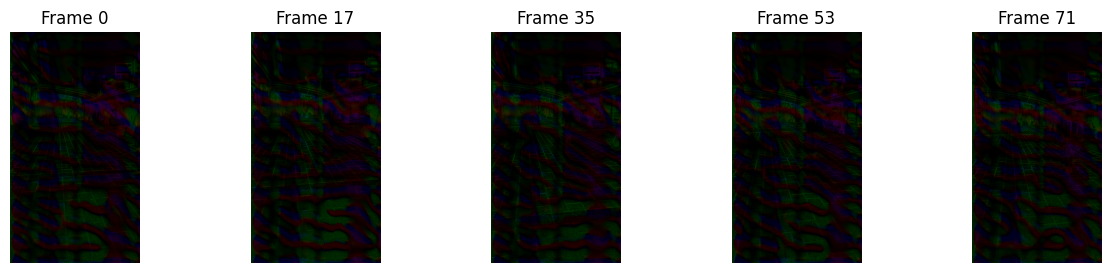

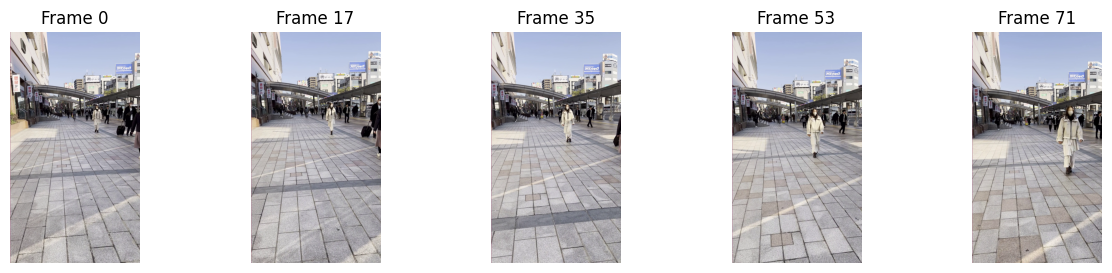

In [18]:
# compressed_video.shape -> torch.Size([t, c, h, w])
def plot_images_from_video_tensor(video_tensor, n=5):
    # prepare images
    video_tensor = video_tensor.clamp(0, 1).permute(0, 2, 3, 1)  # t c h w -> t w h c
    video_tensor = video_tensor.cpu().numpy() 
    # plot
    indexes = np.linspace(0, len(video_tensor)-1, n).astype(int)
    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for ii, idx in enumerate(indexes):
        axes[ii].imshow(video_tensor[idx])
        axes[ii].axis('off')
        axes[ii].set_title(f"Frame {idx}")
    plt.show()

plot_images_from_video_tensor(vid_w-vid, n=5)
plot_images_from_video_tensor(video_tensor, n=5)